In [76]:
# Imports chung
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Dataset

In [48]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [49]:
!wget $data -O course_lead_scoring.csv 

--2025-10-19 21:17:33--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-19 21:17:33 (53.7 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



## Data preparation

In [50]:
df = pd.read_csv('course_lead_scoring.csv')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [51]:
df.describe(include='all')

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
count,1334,1328,1462.000000,1281.000000,1362,1399,1462.000000,1462.000000,1462.000000
unique,5,7,NaN,NaN,4,7,NaN,NaN,NaN
top,organic_search,retail,NaN,NaN,self_employed,north_america,NaN,NaN,NaN
freq,282,203,NaN,NaN,352,225,NaN,NaN,NaN
mean,NaN,NaN,2.031464,59886.273224,NaN,NaN,2.976744,0.506108,0.619015
std,NaN,NaN,1.449717,15070.140389,NaN,NaN,1.681564,0.288465,0.485795
min,NaN,NaN,0.000000,13929.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,1.000000,49698.000000,NaN,NaN,2.000000,0.262500,0.000000
50%,NaN,NaN,2.000000,60148.000000,NaN,NaN,3.000000,0.510000,1.000000
75%,NaN,NaN,3.000000,69639.000000,NaN,NaN,4.000000,0.750000,1.000000


In [52]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [53]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [54]:
df.dtypes == 'object'

lead_source                  True
industry                     True
number_of_courses_viewed    False
annual_income               False
employment_status            True
location                     True
interaction_count           False
lead_score                  False
converted                   False
dtype: bool

In [55]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [59]:
df_filled = df.copy()

# Cột phân loại và cột số
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# Với categorical → thay NaN bằng 'NA'
cat_cols = df_filled.select_dtypes(include=['object']).columns
df_filled[cat_cols] = df_filled[cat_cols].fillna('NA')
# Với numerical → thay NaN bằng 0.0
num_cols = df_filled.select_dtypes(include=['number']).columns
df_filled[num_cols] = df_filled[num_cols].fillna(0.0)

In [60]:
df_filled

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [61]:
df_filled.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [67]:
from sklearn.model_selection import train_test_split

# Bước 1: chia train (60%) và temp (40%)
df_train, df_temp = train_test_split(df_filled, test_size=0.4, random_state=1)

# Bước 2: chia temp thành val (20%) và test (20%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [68]:
len(df_train), len(df_val), len(df_test)

(877, 292, 293)

In [69]:
df_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
340,organic_search,education,3,69033.0,self_employed,north_america,1,0.43,1
596,organic_search,education,3,0.0,student,middle_east,0,0.52,1
457,events,education,1,68118.0,student,north_america,7,0.87,1
175,social_media,finance,0,65044.0,self_employed,africa,5,0.53,1
549,paid_ads,NA,5,48327.0,employed,north_america,0,0.89,1
...,...,...,...,...,...,...,...,...,...
715,referral,NA,2,35103.0,unemployed,africa,0,0.88,0
905,social_media,other,1,66006.0,employed,south_america,5,0.64,1
1096,events,finance,2,73688.0,self_employed,asia,2,0.07,0
235,referral,technology,2,76723.0,employed,north_america,3,0.49,1


In [70]:
df_val

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
528,social_media,technology,3,59337.0,unemployed,africa,2,0.58,1
51,organic_search,technology,2,72662.0,employed,NA,2,0.76,1
1331,referral,education,2,58490.0,unemployed,europe,3,0.82,1
1010,paid_ads,other,5,69765.0,self_employed,north_america,2,0.32,1
1240,social_media,technology,2,77835.0,self_employed,africa,3,0.44,1
...,...,...,...,...,...,...,...,...,...
546,social_media,other,2,79461.0,NA,north_america,3,0.00,0
348,events,manufacturing,1,54467.0,self_employed,asia,3,0.03,0
1420,paid_ads,technology,5,31551.0,unemployed,australia,0,0.72,1
692,referral,finance,0,70544.0,student,australia,1,0.03,0


In [71]:
df_test

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
719,organic_search,technology,1,0.0,employed,middle_east,2,0.90,0
1223,organic_search,retail,1,63548.0,NA,europe,4,0.81,1
336,NA,manufacturing,1,50616.0,unemployed,europe,5,0.63,1
741,NA,technology,2,70002.0,NA,south_america,3,0.06,0
401,social_media,retail,3,64969.0,employed,north_america,1,0.18,0
...,...,...,...,...,...,...,...,...,...
1252,events,technology,2,30210.0,self_employed,europe,4,0.13,1
1364,NA,other,1,61131.0,self_employed,europe,3,0.25,0
742,social_media,retail,2,50611.0,student,middle_east,3,0.37,0
925,events,retail,1,0.0,unemployed,europe,3,0.80,0


In [72]:
# 3️⃣ Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# 4️⃣ In kích thước để kiểm tra
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (877, 9)
Validation shape: (292, 9)
Test shape: (293, 9)


In [77]:
# Định nghĩa các cột
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']
target = 'converted'

# Quick safety checks (in case)
assert target in df_train.columns, "Không tìm thấy cột target trong df_train"

## Question 1: ROC AUC feature importance

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income


Answer: number_of_courses_viewed

In [73]:
# Q1: AUC cho từng biến numerical (sử dụng df_train)
from sklearn.metrics import roc_auc_score

print("Q1: ROC AUC (train set) for numerical features:")
aucs = {}
for col in numerical:
    scores = df_train[col].values
    try:
        auc = roc_auc_score(df_train[target].values, scores)
    except Exception as e:
        auc = np.nan
    # nếu <0.5, đổi dấu và tính lại
    if not np.isnan(auc) and auc < 0.5:
        auc2 = roc_auc_score(df_train[target].values, -scores)
        print(f" {col:25s} -> AUC(before) = {auc:.3f}, (inverted) = {auc2:.3f}")
        aucs[col] = auc2
    else:
        print(f" {col:25s} -> AUC = {auc:.3f}")
        aucs[col] = auc

# In kết luận (biến có AUC lớn nhất)
best_feature = max(aucs, key=lambda k: aucs[k] if not np.isnan(aucs[k]) else -1)
print("\n=> Q1: Best feature (highest AUC):", best_feature, "with AUC =", round(aucs[best_feature],3))


Q1: ROC AUC (train set) for numerical features:
 number_of_courses_viewed  -> AUC = nan
 annual_income             -> AUC = nan
 interaction_count         -> AUC = nan
 lead_score                -> AUC = nan

=> Q1: Best feature (highest AUC): number_of_courses_viewed with AUC = nan


## Question 2. Model AUC (1 point)

- 0.32
- 0.52
- 0.72
- 0.92


Answer: 0.72

In [78]:
# Q2: One-hot encode bằng DictVectorizer, train LR, tính AUC trên validation
dv = DictVectorizer(sparse=False)

X_train = df_train[categorical + numerical]
y_train = df_train[target].values

X_val = df_val[categorical + numerical]
y_val = df_val[target].values

# to_dict và encode
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

# Train Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict proba and AUC
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred)
print("\nQ2: Validation AUC = {:.3f}".format(auc_val))

# For multiple choice, round to 3 decimals and choose nearest option



Q2: Validation AUC = 0.794


## Question 3. Precision and recall (1 point)

- 0.145
- 0.345
- 0.545
- 0.745


Answer: 0.545

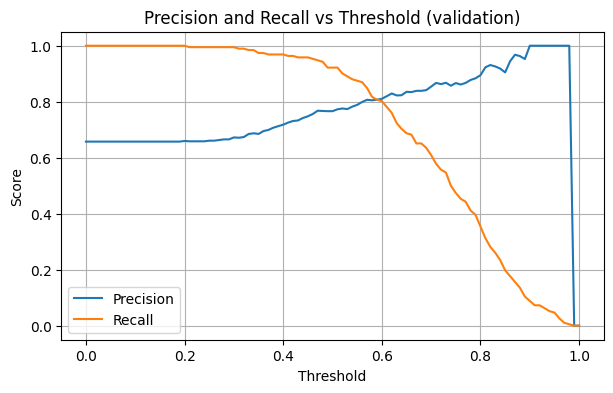


Q3: Precision-Recall Intersection Threshold (approx) = 0.590


In [83]:
# Q3: Precision-Recall vs threshold (use y_val_pred from Q2)
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    precisions.append(p)
    recalls.append(r)

# Plot
plt.figure(figsize=(7,4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold (validation)')
plt.legend()
plt.grid(True)
plt.show()

# Find threshold where |precision - recall| minimal
diff = np.abs(np.array(precisions) - np.array(recalls))
best_idx = np.argmin(diff)
best_threshold = thresholds[best_idx]
print("\nQ3: Precision-Recall Intersection Threshold (approx) = {:.3f}".format(best_threshold))

## Question 4. F1 score (1 point)

- 0.14
- 0.34
- 0.54
- 0.74


Answer: 0.54

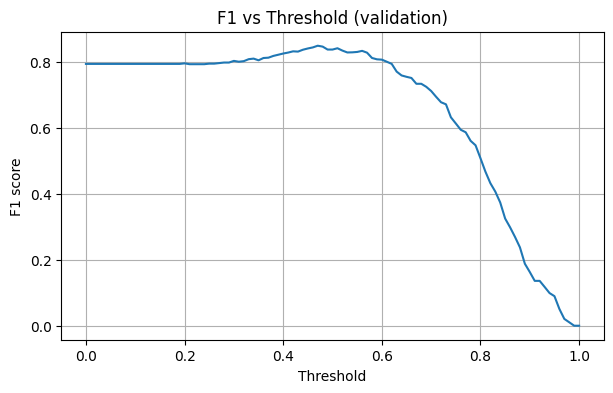


Q4: Best threshold (max F1) = 0.470, Best F1 = 0.848


In [85]:
# Q4: compute F1 for thresholds
f1_scores = []
for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    if p + r == 0:
        f1 = 0.0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

# Plot F1 vs threshold
plt.figure(figsize=(7,4))
plt.plot(thresholds, f1_scores, label='F1')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Threshold (validation)')
plt.grid(True)
plt.show()

best_idx_f1 = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_idx_f1]
best_f1 = f1_scores[best_idx_f1]
print("\nQ4: Best threshold (max F1) = {:.3f}, Best F1 = {:.3f}".format(best_threshold_f1, best_f1))

## Question 5. 5-Fold CV standard deviation (1 point)

- 0.0001
- 0.006
- 0.06
- 0.36


Answer: 0.06

In [86]:
# Q5: 5-Fold CV on df_full_train (concatenate train + val)
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
# confirm target exists in df_full_train
assert target in df_full_train.columns

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_tr = df_full_train.iloc[train_idx]
    df_va = df_full_train.iloc[val_idx]

    X_tr = df_tr[categorical + numerical]
    y_tr = df_tr[target].values

    X_va = df_va[categorical + numerical]
    y_va = df_va[target].values

    # encode
    dv2 = DictVectorizer(sparse=False)
    X_tr_enc = dv2.fit_transform(X_tr.to_dict(orient='records'))
    X_va_enc = dv2.transform(X_va.to_dict(orient='records'))

    # train & predict
    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_tr_enc, y_tr)
    y_va_pred = model_cv.predict_proba(X_va_enc)[:, 1]
    auc_fold = roc_auc_score(y_va, y_va_pred)
    auc_scores.append(auc_fold)

print("\nQ5: AUC scores per fold:", auc_scores)
print("Mean AUC:", np.mean(auc_scores))
print("STD AUC:", np.std(auc_scores))


Q5: AUC scores per fold: [0.806680393502631, 0.8067501795260512, 0.8648193508879363, 0.8334380892520429, 0.8153846153846154]
Mean AUC: 0.8254145257106554
STD AUC: 0.021986552473681004


## Question 6. Best C (1 point)

- 0.000001
- 0.001
- 1


Answer: 0.001

In [88]:
# Q6: hyperparameter tuning with KFold
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}  # C -> (mean, std, list_of_scores)

for C in C_values:
    aucs_C = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx]
        df_va = df_full_train.iloc[val_idx]

        X_tr = df_tr[categorical + numerical]
        y_tr = df_tr[target].values

        X_va = df_va[categorical + numerical]
        y_va = df_va[target].values

        dv_c = DictVectorizer(sparse=False)
        X_tr_enc = dv_c.fit_transform(X_tr.to_dict(orient='records'))
        X_va_enc = dv_c.transform(X_va.to_dict(orient='records'))

        model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_c.fit(X_tr_enc, y_tr)
        y_va_pred = model_c.predict_proba(X_va_enc)[:, 1]
        aucs_C.append(roc_auc_score(y_va, y_va_pred))

    mean_auc = round(np.mean(aucs_C), 3)
    std_auc = round(np.std(aucs_C), 3)
    results[C] = (mean_auc, std_auc, aucs_C)
    print(f"C={C:9g} -> Mean AUC={mean_auc}, Std={std_auc}, scores={np.round(aucs_C,3)}")

# Select best C according to rules: best mean, tie -> lowest std, tie -> smallest C
# build sorted list of (mean, -std, -C) so that max gives correct tie-breaking
best = None
for C, (mean_auc, std_auc, scores) in results.items():
    key = (mean_auc, -std_auc, -C)  # higher mean, higher -std (lower std), higher -C (smaller C) wins
    if best is None or key > best[0]:
        best = (key, C, results[C])

best_C = best[1]
best_mean, best_std, _ = best[2]
print("\nQ6: Best C =", best_C, "with Mean AUC =", best_mean, "and Std =", best_std)

C=    1e-06 -> Mean AUC=0.543, Std=0.025, scores=[0.59  0.516 0.537 0.531 0.543]
C=    0.001 -> Mean AUC=0.864, Std=0.014, scores=[0.861 0.84  0.884 0.871 0.866]
C=        1 -> Mean AUC=0.825, Std=0.022, scores=[0.807 0.807 0.865 0.833 0.815]

Q6: Best C = 0.001 with Mean AUC = 0.864 and Std = 0.014
